The other Notebook became a bit much, so I'll be working on visualisations in this Notebook, copying the main functions from `MR-analyse-proximus-mobility-data.ipynb`

# Calculating baseline $P^{gh}$

In [2]:
from datetime import date, datetime, timedelta
# import pandas as pd
import numpy as np
import glob
%matplotlib notebook
import matplotlib.pyplot as plt
import sys
import datetime
# sys.path.insert(0, "../tools")
from covid19model.data.mobility import * # contains all necessary functions
from covid19model.visualization.output import *

# OPTIONAL: Load the "autoreload" extension so that package code can change
%load_ext autoreload
# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

In [5]:
# First load the data and inspect the mobility for this date range

### FILL IN AGGREGATION ###

agg = 'arr'
filename = 'fractional-mobility-matrix_staytime_' + agg + '_'
data_location = '../../data/interim/mobility/' + agg + '/staytime/'

from datetime import date, datetime, timedelta
dates_prelockdown=[]
dates_prelockdown_datetime=[]

# Define date range
sdate_prelockdown = datetime(2020, 2, 10, 0, 0)   # start date
edate_prelockdown = datetime(2020, 3, 15, 0, 0)   # end date
delta = edate_prelockdown - sdate_prelockdown       # as timedelta

# Fill arrays with YYYYMMDD dates and datetime dates
for i in range(delta.days + 1):
    day = sdate_prelockdown + timedelta(days=i)
    dates_prelockdown_datetime.append(day)
    dates_prelockdown.append(date_to_YYYYMMDD(day))
    
# Load dictionary with YYYYMMDD dates as keys and P-matrices as values
mmprox_prelockdown, missing_dates = load_Pmatrix_staytime(dates_prelockdown, data_location, \
                                        complete=False, verbose=True, return_missing=True, agg=agg)

# date array for xaxis (takes care of missing dates: needs same number of elements in array!)
dates_prelockdown_xaxis = dates_prelockdown_datetime.copy()
for d in missing_dates:
    dates_prelockdown_xaxis.remove(date_to_YYYYMMDD(d, inverse=True))

... proceeding with 34 dates.
Loaded dataframe for date 20200315.


In [6]:
# Make arrays of relevant days
vacation_days=[]
business_days=[]
weekend_days=[]
vacation_dict=dict({})
business_dict=dict({})
weekend_dict=dict({})

vacation_sdate = datetime(2020, 2, 24, 0, 0)   # start date of Easter vacation
for i in range(7):
    day = vacation_sdate + timedelta(days=i)
    day_YYYYMMDD = date_to_YYYYMMDD(day)
    vacation_days.append(day_YYYYMMDD)
    if day_YYYYMMDD in mmprox_prelockdown:
        vacation_dict[day_YYYYMMDD] = mmprox_prelockdown[day_YYYYMMDD]
    
for d in mmprox_prelockdown:
    if d not in vacation_days:
        d_datetime = date_to_YYYYMMDD(d, inverse=True)
        if d_datetime.isoweekday() in [6,7]:
            weekend_days.append(d)
            if d in mmprox_prelockdown:
                weekend_dict[d] = mmprox_prelockdown[d]
        else:
            business_days.append(d)
            if d in mmprox_prelockdown:
                business_dict[d] = mmprox_prelockdown[d]

In [7]:
# Calculate average matrices and average total sums
mmprox_baseline_vacation = average_mobility(vacation_dict)
mmprox_baseline_business = average_mobility(business_dict)
mmprox_baseline_weekend = average_mobility(weekend_dict)

# Inspect
mmprox_baseline_vacation.head()

,11000,12000,13000,21000,23000,24000,25000,31000,32000,33000,...,73000,81000,82000,83000,84000,85000,91000,92000,93000,ABROAD
mllp_postalcode,,,,,,,,,,,,,,,,,,,,,
11000,0.902791,0.017148,0.011762,0.006268,0.007939,0.006186,0.001849,0.003175,0.000230,0.000596,...,0.001304,0.000297,0.000799,0.000950,0.000976,0.000231,0.001077,0.001012,0.000243,0.0
12000,0.051704,0.821255,0.015782,0.011576,0.023047,0.023685,0.002432,0.002398,0.000218,0.000696,...,0.001454,0.000374,0.000927,0.000986,0.000864,0.000288,0.001200,0.001190,0.000277,0.0
13000,0.030690,0.012100,0.885865,0.003345,0.004983,0.015281,0.001406,0.001748,0.000181,0.000420,...,0.001964,0.000237,0.000782,0.000858,0.000530,0.000178,0.000726,0.000710,0.000201,0.0
21000,0.003658,0.001895,0.001225,0.887854,0.039752,0.005711,0.014925,0.002228,0.000127,0.000364,...,0.000621,0.000479,0.000674,0.000838,0.001057,0.000784,0.001810,0.002943,0.000549,0.0
23000,0.007627,0.010267,0.002464,0.093050,0.783698,0.015052,0.014476,0.002692,0.000228,0.000629,...,0.000944,0.000452,0.000670,0.001065,0.001124,0.000397,0.001661,0.002581,0.000557,0.0


In [8]:
# Save for future reference
save_again = False

if save_again:
    savename_vacation = "fractional-mobility-matrix_staytime_" + agg + "_baseline-vacation.csv"
    savename_business = "fractional-mobility-matrix_staytime_" + agg + "_baseline-business.csv"
    savename_weekend = "fractional-mobility-matrix_staytime_" + agg + "_baseline-weekend.csv"

    save_location = "../../data/interim/mobility/" + agg + "/baseline/"

    mmprox_baseline_vacation.to_csv(save_location + savename_vacation)
    mmprox_baseline_business.to_csv(save_location + savename_business)
    mmprox_baseline_weekend.to_csv(save_location + savename_weekend)

# Visualising pre-lockdown and baseline $P^{gh}$

In [9]:
# Load baseline mobility data
agg = 'arr'
load_location = "../../data/interim/mobility/" + agg + "/baseline/"
loadname_vacation = "fractional-mobility-matrix_staytime_" + agg + "_baseline-vacation.csv"
loadname_business = "fractional-mobility-matrix_staytime_" + agg + "_baseline-business.csv"
loadname_weekend = "fractional-mobility-matrix_staytime_" + agg + "_baseline-weekend.csv"

mmprox_baseline_vacation = pd.read_csv(load_location + loadname_vacation, index_col='mllp_postalcode')
mmprox_baseline_business = pd.read_csv(load_location + loadname_business, index_col='mllp_postalcode')
mmprox_baseline_weekend = pd.read_csv(load_location + loadname_weekend, index_col='mllp_postalcode')

mmprox_baseline_weekend.head()

,11000,12000,13000,21000,23000,24000,25000,31000,32000,33000,...,73000,81000,82000,83000,84000,85000,91000,92000,93000,ABROAD
mllp_postalcode,,,,,,,,,,,,,,,,,,,,,
11000,0.918069,0.012574,0.010464,0.003286,0.005786,0.005285,0.001512,0.003883,0.000227,0.000577,...,0.001391,0.000227,0.000999,0.001291,0.001176,0.000286,0.001361,0.000972,0.000282,0.0
12000,0.032939,0.869480,0.013116,0.004311,0.015916,0.017763,0.001789,0.002482,0.000231,0.000627,...,0.001382,0.000198,0.001033,0.001287,0.000953,0.000309,0.001356,0.001017,0.000321,0.0
13000,0.020195,0.009043,0.916185,0.001917,0.003401,0.010433,0.000777,0.001697,0.000157,0.000389,...,0.001786,0.000149,0.000946,0.001056,0.000572,0.000139,0.000818,0.000508,0.000104,0.0
21000,0.003693,0.001700,0.001298,0.887783,0.033897,0.005528,0.013895,0.002678,0.000153,0.000494,...,0.000794,0.000566,0.000941,0.001132,0.001318,0.000967,0.002411,0.003446,0.000654,0.0
23000,0.005992,0.008202,0.002094,0.052944,0.838215,0.012630,0.013040,0.002683,0.000222,0.000561,...,0.000918,0.000366,0.000749,0.001338,0.001246,0.000410,0.001946,0.002422,0.000548,0.0


In [10]:
# Defining values to plot in array

NIS_from = '21000'
NIS_to = '11000'

fractions=[]
for d in mmprox_prelockdown:
    fraction = mmprox_prelockdown[d].loc[NIS_from, NIS_to]
    fractions.append(fraction)

# Define baseline values for NIS couple
vacation_baseline = mmprox_baseline_vacation.loc[NIS_from, NIS_to]
business_baseline = mmprox_baseline_business.loc[NIS_from, NIS_to]
weekend_baseline = mmprox_baseline_weekend.loc[NIS_from, NIS_to]

<IPython.core.display.Javascript object>


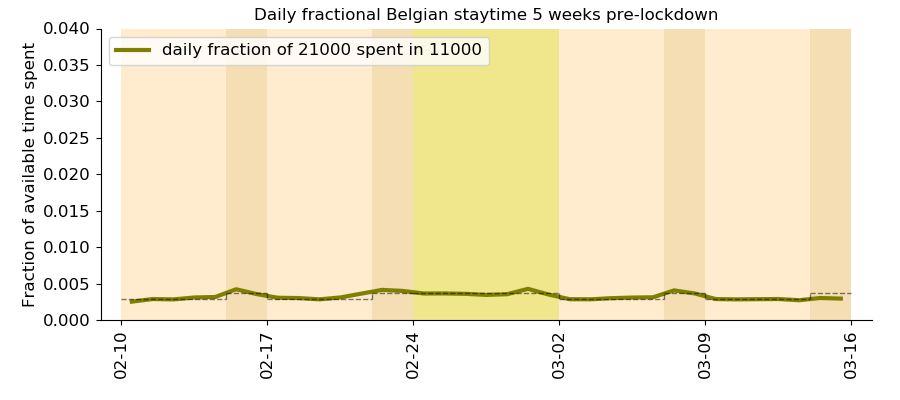

In [11]:
# Plotting environment

import matplotlib.dates as mdates
fontsize=12
color='olive'
data_label=f'daily fraction of {NIS_from} spent in {NIS_to}'
symlog=False
    
fig, ax1 = plt.subplots(figsize=(9,4))
ax1.grid(False)

ax1.set_ylabel('Fraction of available time spent', fontsize=fontsize)
ax1.tick_params(axis='y', labelsize=fontsize)
# ax1.set_xlabel('Date', fontsize=fontsize)
ax1.tick_params(axis='x', labelsize=fontsize)
myFmt = mdates.DateFormatter('%m-%d')
ax1.xaxis.set_major_formatter(myFmt)
ax1.set_xlim([dates_prelockdown_datetime[0]-timedelta(1), dates_prelockdown_datetime[-1]+timedelta(2)])
xticks_prelockdown = dates_prelockdown_datetime[0:-1:7] + [dates_prelockdown_datetime[-1]+timedelta(1)]
ax1.set_xticks(xticks_prelockdown)
# ax1.set_ylim(0, 1)
ax1.set_ylim(0, .04)

if symlog:
    linthresh_power = -2
    ax1.set_yscale('symlog', linthreshy=10**linthresh_power)
    ax1.set_yticks([0]+[10**i for i in range(linthresh_power, 1, 1)])

# Shift 12 hours to the right for a nicer visualisation
dates_prelockdown_xaxis_shifted = np.array(dates_prelockdown_xaxis)+timedelta(hours=12)
ax1.plot(dates_prelockdown_xaxis_shifted, fractions, label=data_label, color=color)
fig.tight_layout()  # otherwise the right y-label is slightly clipped

plt.title('Daily fractional Belgian staytime 5 weeks pre-lockdown', fontsize=fontsize)
fig.autofmt_xdate(bottom=.2, rotation=90, ha='center', which=None) # Automatic x-tick fix!

# Add coloured bands
color_timeframes(sdate_prelockdown, edate_prelockdown, ax=ax1)

# Draw baselines
baselines = (business_baseline, weekend_baseline, vacation_baseline)
draw_baseline(sdate_prelockdown, edate_prelockdown, baselines, ax=ax1)

plt.legend(fontsize=fontsize)
plt.show()

In [38]:
baselines

(0.026887568773706818, 0.008206308124112023, 0.0204322368418117)

# Visualising lockdown period

In [12]:
# Load the data

### FILL IN AGGREGATION ###

agg = 'arr'
filename = 'fractional-mobility-matrix_staytime_' + agg + '_'
data_location = '../../data/interim/mobility/' + agg + '/staytime/'

from datetime import date, datetime, timedelta
dates=[]
dates_datetime=[]

# Define date range we want to load and plot
sdate = datetime(2020, 1, 31, 0, 0)   # start date
edate = datetime(2021, 1, 31, 0, 0)   # end date
delta = edate - sdate                 # as timedelta

# Fill arrays with YYYYMMDD dates and datetime dates
for i in range(delta.days + 1):
    day = sdate + timedelta(days=i)
    dates_datetime.append(day)
    dates.append(date_to_YYYYMMDD(day))
    
# Load dictionary with YYYYMMDD dates as keys and P-matrices as values
mmprox, missing_dates = load_Pmatrix_staytime(dates, data_location, \
                                        complete=False, verbose=True, return_missing=True, agg=agg)

# date array for xaxis (takes care of missing dates: needs same number of elements in array!)
dates_xaxis = dates_datetime.copy()
for d in missing_dates:
    dates_xaxis.remove(date_to_YYYYMMDD(d, inverse=True))

... proceeding with 351 dates.
Loaded dataframe for date 20210127.    


In [13]:
# Defining values to plot in array

NIS_from = '21000' #bxl
NIS_to = '21000' #bxl

fractions=[]
for d in mmprox:
    fraction = mmprox[d].loc[NIS_from, NIS_to]
    fractions.append(fraction)
    
# Define baseline values for NIS couple
vacation_baseline = mmprox_baseline_vacation.loc[NIS_from, NIS_to]
business_baseline = mmprox_baseline_business.loc[NIS_from, NIS_to]
weekend_baseline = mmprox_baseline_weekend.loc[NIS_from, NIS_to]
    
NIS_from2 = '21000'
NIS_to2 = '11000' #gent

fractions2=[]
for d in mmprox:
    fraction2 = mmprox[d].loc[NIS_from2, NIS_to2]
    fractions2.append(fraction2)
    
# Define baseline values for 2nd NIS couple
vacation_baseline2 = mmprox_baseline_vacation.loc[NIS_from2, NIS_to2]
business_baseline2 = mmprox_baseline_business.loc[NIS_from2, NIS_to2]
weekend_baseline2 = mmprox_baseline_weekend.loc[NIS_from2, NIS_to2]

<IPython.core.display.Javascript object>


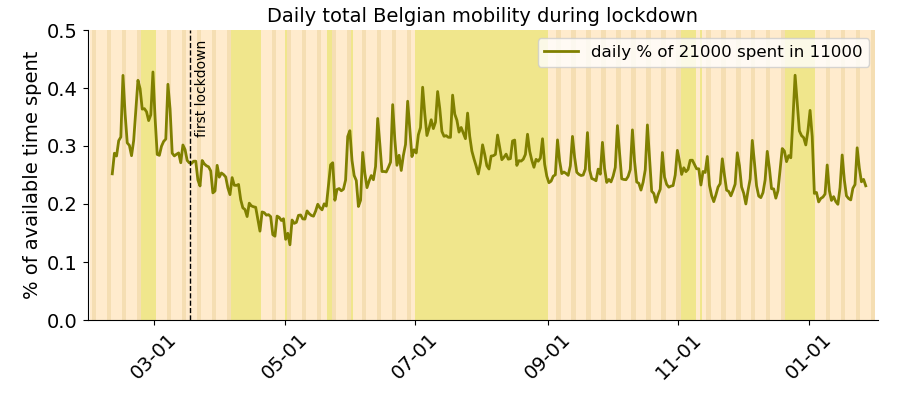

In [15]:
# Plotting environment
from covid19model.visualization.output import color_timeframes
import matplotlib.dates as mdates
import datetime

percentage=True
pct_factor=1
if percentage:
    pct_factor=100

fontsize=14
color_daily='lightsalmon'
alpha_daily=1
color_daily2='olive'
alpha_daily2=1
if percentage:
    data_label=f'daily % of {NIS_from} spent in {NIS_to}'
    data_label2=f'daily % of {NIS_from2} spent in {NIS_to2}'
else:
    data_label=f'daily fraction of {NIS_from} spent in {NIS_to}'
    data_label2=f'daily fraction of {NIS_from2} spent in {NIS_to2}'
symlog=False
tick_interval = 14 # days
    
fig, ax2 = plt.subplots(figsize=(9, 4))
ax2.grid(False)

if percentage:
    ax2.set_ylabel('% of available time spent', fontsize=fontsize)
else:
    ax2.set_ylabel('Fraction of available time spent', fontsize=fontsize)
ax2.tick_params(axis='y', labelsize=fontsize)
# ax2.set_xlabel('Date', fontsize=fontsize)
ax2.tick_params(axis='x', labelsize=fontsize)
myFmt = mdates.DateFormatter('%m-%d')
ax2.xaxis.set_major_formatter(myFmt)
ax2.set_xlim([dates_datetime[0]-datetime.timedelta(1), dates_datetime[-1]+datetime.timedelta(2)])
xticks = dates_datetime[0:-1:tick_interval] + [dates_datetime[-1]+datetime.timedelta(1)]
# ax2.set_xticks(xticks)
ax2.set_ylim(0, pct_factor*.005)

if symlog:
    linthresh_power = -3
    ax2.set_yscale('symlog', linthreshy=10**linthresh_power)
    ax2.set_yticks([0]+[10**i for i in range(linthresh_power, 1, 1)])

dates_datetime_shifted = np.array(dates_xaxis)+datetime.timedelta(hours=12)
# ax2.plot(dates_datetime_shifted, fractions, label=data_label, alpha=alpha_daily, linewidth=2,color=color_daily)
ax2.plot(dates_datetime_shifted, pct_factor*np.array(fractions2), label=data_label2, alpha=alpha_daily, linewidth=2, color=color_daily2)
fig.tight_layout()  # otherwise the right y-label is slightly clipped

plt.title('Daily total Belgian mobility during lockdown', fontsize=fontsize)
fig.autofmt_xdate(bottom=.2, rotation=90, ha='center', which=None) # Automatic x-tick fix!

# Draw background
color_timeframes(sdate, edate, ax=ax2)

# Draw baselines
baselines = (business_baseline, weekend_baseline, vacation_baseline)
# draw_baseline(sdate, edate, baselines, ax=ax2)

baselines2 = (business_baseline2, weekend_baseline2, vacation_baseline2)
# draw_baseline(sdate, edate, baselines2, ax=ax2)

# Draw start of first lockdown
lockdowndate = datetime.datetime(2020, 3, 18, 0, 0)
ax2.axvline(lockdowndate, linewidth=1, color='k', linestyle='--')
ax2.text(lockdowndate + datetime.timedelta(days=2), pct_factor*0.0032, "first lockdown", size=10, rotation=90) # March 18th: 

plt.legend(fontsize=fontsize-2)#, bbox_to_anchor=(.98, .9), loc='center right')
plt.xticks(rotation=45)

# plt.savefig("../../delete_me.png", dpi=200)

Plot the fractional change between regular mobility and lockdown mobility

In [47]:
# Load baseline values

agg = 'mun'
load_location = "../../data/interim/mobility/" + agg + "/baseline/"
loadname_vacation = "fractional-mobility-matrix_staytime_" + agg + "_baseline-vacation.csv"
loadname_business = "fractional-mobility-matrix_staytime_" + agg + "_baseline-business.csv"
loadname_weekend = "fractional-mobility-matrix_staytime_" + agg + "_baseline-weekend.csv"

mmprox_baseline_vacation = pd.read_csv(load_location + loadname_vacation, index_col='mllp_postalcode')
mmprox_baseline_business = pd.read_csv(load_location + loadname_business, index_col='mllp_postalcode')
mmprox_baseline_weekend = pd.read_csv(load_location + loadname_weekend, index_col='mllp_postalcode')

In [50]:
#2 Defining values to plot in array

NIS_from = '21004' #bxl
NIS_to = '21004' #bxl
    
# Define baseline values for NIS couple
baseline=dict({})
baseline['vacation'] = mmprox_baseline_vacation.loc[NIS_from, NIS_to]
baseline['business'] = mmprox_baseline_business.loc[NIS_from, NIS_to]
baseline['weekend'] = mmprox_baseline_weekend.loc[NIS_from, NIS_to]

pi_gh=[]
for d in mmprox:
    pi_gh_newvalue = mmprox[d].loc[NIS_from, NIS_to] / baseline[check_dtype(date_to_YYYYMMDD(d, inverse=True))]
    pi_gh.append(pi_gh_newvalue)


NIS_from2 = '21004' #bxl
NIS_to2 = '21005' #bxl
    
# Define baseline values for NIS couple
baseline2=dict({})
baseline2['vacation'] = mmprox_baseline_vacation.loc[NIS_from2, NIS_to2]
baseline2['business'] = mmprox_baseline_business.loc[NIS_from2, NIS_to2]
baseline2['weekend'] = mmprox_baseline_weekend.loc[NIS_from2, NIS_to2]

pi_gh2=[]
for d in mmprox:
    pi_gh2_newvalue = mmprox[d].loc[NIS_from2, NIS_to2] / baseline2[check_dtype(date_to_YYYYMMDD(d, inverse=True))]
    pi_gh2.append(pi_gh2_newvalue)

[0.8355402342167325,
 1.0497018542617826,
 1.0236424371733206,
 1.0224954036305003,
 0.9555341253865405,
 1.1737852262145028,
 0.9925816892170777,
 1.0587475109482762,
 1.1189547151662849,
 1.0696233040508971,
 1.0637816166683247,
 1.1042143455949451,
 0.946574702184912,
 1.2309312651198745,
 1.2975223871705819,
 1.2852268168126106,
 1.2737756728914997,
 1.1133086052219783,
 0.4322108022080225,
 0.3670244505754339,
 1.0084039112803556,
 1.0841807738802283,
 1.0283090817190381,
 1.0424870133828765,
 0.9389906099126408,
 1.0585639825264406,
 0.9689896784200233,
 1.0040562863856304,
 1.0291069861262747,
 0.9517637554818292,
 0.9393135982419856,
 0.7753667820864879,
 0.932992315915364,
 0.8222980599267341,
 0.4488241068095852,
 0.4088906822147471,
 0.3502606733970293,
 0.3142418565568367,
 0.3046998823030272,
 0.7220904512382664,
 0.7399103980754254,
 0.2997195772231592,
 0.2911887147103504,
 0.2861207692085842,
 0.29636807967782536,
 0.273477624714023,
 0.6938014407233791,
 0.608897580959

<IPython.core.display.Javascript object>


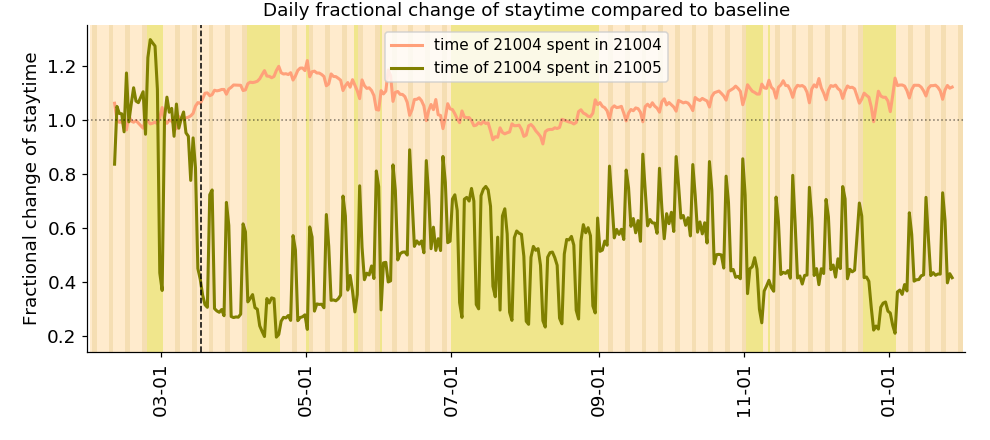

In [56]:
# Plotting environment
from covid19model.visualization.output import color_timeframes
import matplotlib.dates as mdates
import datetime
fontsize=12
color_daily='lightsalmon'
alpha_daily=1
color_daily2='olive'
alpha_daily2=1
data_label=f'time of {NIS_from} spent in {NIS_to}'
data_label2=f'time of {NIS_from2} spent in {NIS_to2}'
symlog=False
tick_interval = 14 # days
    
fig, ax3 = plt.subplots(figsize=(9, 4))
ax3.grid(False)

ax3.set_ylabel('Fractional change of staytime', fontsize=fontsize)
ax3.tick_params(axis='y', labelsize=fontsize)
# ax3.set_xlabel('Date', fontsize=fontsize)
ax3.tick_params(axis='x', labelsize=fontsize)
myFmt = mdates.DateFormatter('%m-%d')
ax3.xaxis.set_major_formatter(myFmt)
ax3.set_xlim([dates_datetime[0]-datetime.timedelta(1), dates_datetime[-1]+datetime.timedelta(2)])
xticks = dates_datetime[0:-1:tick_interval] + [dates_datetime[-1]+datetime.timedelta(1)]
# ax3.set_xticks(xticks)
# ax3.set_ylim(0, .04)

if symlog:
    linthresh_power = -3
    ax3.set_yscale('symlog', linthreshy=10**linthresh_power)
    ax3.set_yticks([0]+[10**i for i in range(linthresh_power, 1, 1)])

dates_datetime_shifted = np.array(dates_xaxis)+datetime.timedelta(hours=12)
ax3.plot(dates_datetime_shifted, pi_gh, label=data_label, alpha=alpha_daily, linewidth=2,color=color_daily)
ax3.plot(dates_datetime_shifted, pi_gh2, label=data_label2, alpha=alpha_daily, linewidth=2, color=color_daily2)
fig.tight_layout()  # otherwise the right y-label is slightly clipped

plt.title('Daily fractional change of staytime compared to baseline', fontsize=fontsize)
fig.autofmt_xdate(bottom=.2, rotation=90, ha='center', which=None) # Automatic x-tick fix!

# Draw background
color_timeframes(sdate, edate, ax=ax3)

# Draw baselines
baselines = (business_baseline, weekend_baseline, vacation_baseline)
# draw_baseline(sdate, edate, baselines, ax=ax2)

baselines2 = (business_baseline2, weekend_baseline2, vacation_baseline2)
# draw_baseline(sdate, edate, baselines2, ax=ax2)

# Draw start of first lockdown
lockdowndate = datetime.datetime(2020, 3, 18, 0, 0)
ax3.axvline(lockdowndate, linewidth=1, color='k', linestyle='--')
# ax3.text(lockdowndate + datetime.timedelta(days=2), 0.015, "March 18: first lockdown", size=10, rotation=90)

# Draw baseline unity line
ax3.axhline(1, color='k', linestyle=':', alpha=0.5, linewidth=1)

plt.legend(fontsize=fontsize-2)#, bbox_to_anchor=(.98, .9), loc='center right')

# Create boxplot for ages in particular arrondissement

In [22]:
read_file = "../../data/interim/demographic/age_structure_per_arr.csv"
age_per_arr = pd.read_csv(read_file)
age_per_arr[age_per_arr['NIS']==21000]

,NIS,age,number
322,21000,0,16600
323,21000,1,16785
324,21000,2,16660
325,21000,3,16467
326,21000,4,16456
...,...,...,...
429,21000,107,2
430,21000,108,1
431,21000,109,1
432,21000,110,1


<IPython.core.display.Javascript object>


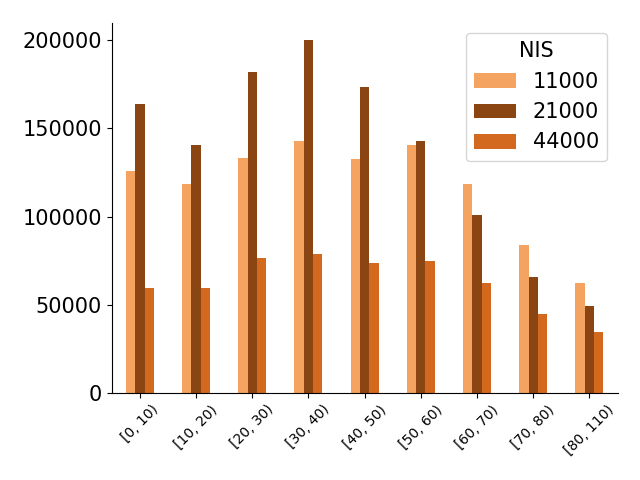

In [17]:
nis=[21000, 11000, 44000]
age_per_arr_agg = pd.read_csv("../../data/interim/demographic/initN_arr.csv").drop(columns="total")
# age_per_arr_agg = age_per_arr_agg[age_per_arr_agg['NIS']==nis]
# age_per_arr_agg[age_per_arr_agg['NIS']==nis].set_index('NIS').T


age_per_arr_agg[age_per_arr_agg['NIS'].isin(nis)].set_index('NIS').T.plot(kind='bar', color=['sandybrown', 'saddlebrown', 'chocolate'])
# plt.xlabel(["<10","<20","<30","<40","<50","<60","<70","<80",">80"])
plt.xticks(rotation=45, size=10)
plt.grid(False)
plt.tight_layout()

plt.savefig("../../delete_me.png", dpi=200)

<IPython.core.display.Javascript object>


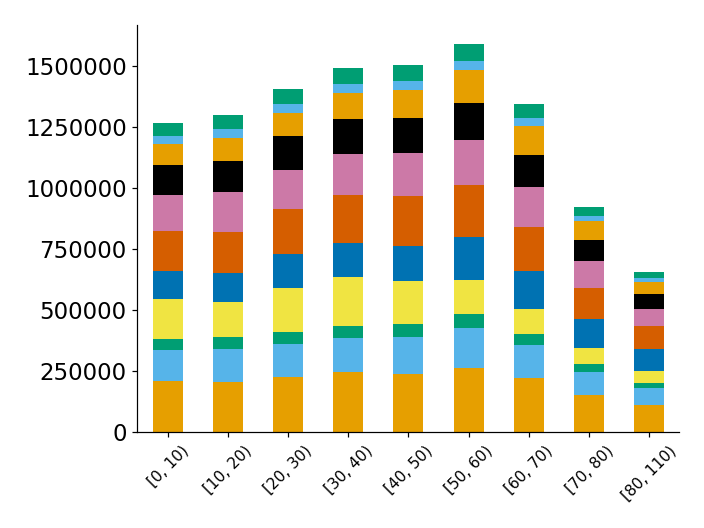

In [88]:
# population per age per province, stacked
age_per_arr_agg = pd.read_csv("../../data/interim/demographic/initN_prov.csv").drop(columns="total")
# age_per_arr_agg = age_per_arr_agg[age_per_arr_agg['NIS']==nis]
# age_per_arr_agg[age_per_arr_agg['NIS']==nis].set_index('NIS').T


age_per_arr_agg.set_index('NIS').T.plot.bar(legend=None, stacked=True)#, color=['sandybrown', 'saddlebrown', 'chocolate'])
# plt.xlabel(["<10","<20","<30","<40","<50","<60","<70","<80",">80"])
plt.xticks(rotation=45, size=10)
plt.grid(False)
plt.tight_layout()

<IPython.core.display.Javascript object>


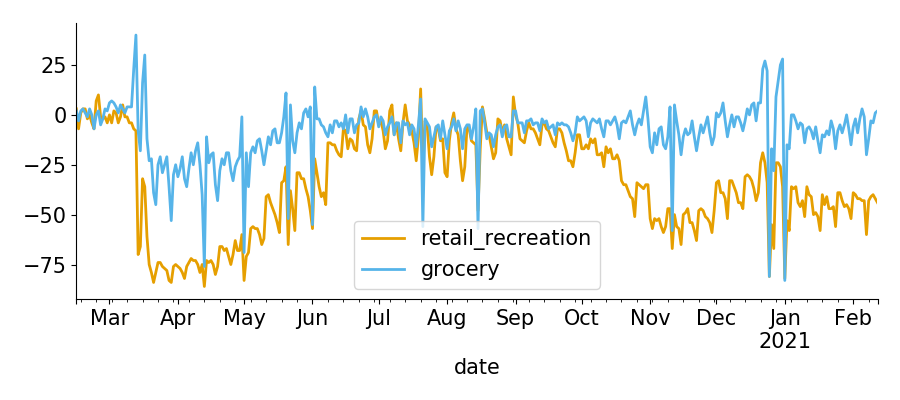

In [3]:
gmd = get_google_mobility_data(update=False, plot=False)


linewidth=2
fig, ax4 = plt.subplots(figsize=(9, 4))
gmd[['retail_recreation']].plot(ax=ax4, linewidth=linewidth)
gmd[['grocery']].plot(ax=ax4, linewidth=linewidth)
ax4.grid(False)
plt.tight_layout()

plt.savefig("../../delete_me.png", dpi=200)

In [141]:
gmd.columns

Index(['retail_recreation', 'grocery', 'parks', 'transport', 'work',
       'residential'],
      dtype='object')